In [83]:
import numpy as np
import pandas as pd

import spice_net as spn

In [84]:
df = pd.read_csv('data/weather_classification_data.csv')
df = df[(df['Location'] == 'mountain') & (df['Weather Type'] == 'Sunny')]
max_humidity = df['Humidity'].max()
df['cleaned_humidity'] = df['Humidity'].apply(lambda x: x / max_humidity)
max_visibility = df['Visibility (km)'].max()
df['cleaned_visibility'] = df['Visibility (km)'].apply(lambda x: x / max_visibility)
df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type,cleaned_humidity,cleaned_visibility
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny,0.587156,0.282051
18,43.0,46,0.5,15.0,clear,1025.80,9,Spring,6.0,mountain,Sunny,0.422018,0.307692
22,33.0,36,7.5,18.0,clear,1014.29,8,Summer,9.5,mountain,Sunny,0.330275,0.487179
28,24.0,61,6.5,3.0,partly cloudy,1018.15,7,Autumn,5.5,mountain,Sunny,0.559633,0.282051
41,36.0,22,1.0,0.0,clear,1028.63,10,Summer,5.5,mountain,Sunny,0.201835,0.282051
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13146,32.0,59,3.5,13.0,clear,1016.91,11,Autumn,5.5,mountain,Sunny,0.541284,0.282051
13154,31.0,55,7.0,7.0,partly cloudy,1013.42,9,Winter,6.0,mountain,Sunny,0.504587,0.307692
13157,33.0,48,1.5,0.0,clear,1024.96,11,Spring,8.0,mountain,Sunny,0.440367,0.410256
13172,33.0,54,0.5,15.0,clear,1012.66,7,Spring,9.0,mountain,Sunny,0.495413,0.461538


In [85]:
som_size = 20

som_1 = spn.SpiceNetSom(n_neurons=som_size,
                        value_range_start=df['cleaned_humidity'].min(),
                        value_range_end=df['cleaned_humidity'].max(),
                        lrf_tuning_curve=spn.ConstLRF(0.8),
                        lrf_interaction_kernel=spn.ConstLRF(0.8))
som_2 = spn.SpiceNetSom(n_neurons=som_size,
                        value_range_start=df['cleaned_visibility'].min(),
                        value_range_end=df['cleaned_visibility'].max(),
                        lrf_tuning_curve=spn.ConstLRF(0.8),
                        lrf_interaction_kernel=spn.ConstLRF(0.8))

correlation_matrix = spn.SpiceNetHcm(som_1=som_1,
                                     som_2=som_2,
                                     lrf_weights=spn.ConstLRF(0.5),  # spn.ExpEDecayLRF(0.003, 0.3, 0.6)
                                     lrf_trust_of_new=spn.ExpEDecayLRF(0.3, 0.25, 0.3))

spice_net = spn.SpiceNet(correlation_matrix)

In [86]:
config_1 = {'sample_set_size': 200, 'epochs_on_batch': 200, 'batch_size': 40}
config_2 = {'sample_set_size': 1000, 'epochs_on_batch': 50, 'batch_size': 100}

config = config_2
sample_set_size = config['sample_set_size']
sub_set = df.sample(n=sample_set_size)
train_set = sub_set[:int(sample_set_size * 0.8)]
test_set = sub_set[int(sample_set_size * 0.8):]

In [87]:
spice_net.fit(train_set['cleaned_humidity'].tolist(), train_set['cleaned_visibility'].tolist(),
              epochs_on_batch=config['epochs_on_batch'],
              batch_size=config['batch_size'],
              print_output=True)
spn.plot_som(som_1, True)
spn.plot_som(som_2, True)
spn.plot_hcm(correlation_matrix)

100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

Time spend on the Components: 
Som: 3.334897994995117 s | Convolution Matrix: 2.5741333961486816 s


In [88]:
import plotly.express as px

errors = []
errors_distance = []
predicted_values = []

for _, row in test_set.iterrows():
    inti_test_value = row['cleaned_humidity']
    result_test_value = row['cleaned_visibility'] * max_visibility
    predicted = spice_net.decode_som_1(inti_test_value) * max_visibility
    predicted_values.append(predicted)
    errors.append(abs(predicted - result_test_value) / max_visibility * 100)
    errors_distance.append(abs(predicted - result_test_value))
    print(
        f'Error: {errors[-1]:.6f},\t Distance: {errors_distance[-1]:.6f}, Predicted: {predicted:.6f},\t Actual: {result_test_value:.6f}')

print('------------------------------------')
print(f'test set length: {len(test_set)}')
print(f'Mean Error in km {np.mean(np.array(errors_distance))}')
print(f'Mean Error in % {np.mean(np.array(errors))}')
print(f'Median Error in % {np.median(np.array(errors))}')

direction = test_set['Visibility (km)'].to_numpy() - np.array(predicted_values)
error_df = pd.DataFrame(
    {'Index': range(1, len(errors) + 1),
     'Real': test_set['Visibility (km)'],
     'Distance': errors_distance,
     'dir': direction.tolist()})
fig = px.scatter(error_df, x="Index", y="Real", error_y="Distance")
fig.add_scatter(x=error_df['Index'].to_numpy(), y=predicted_values, fillcolor='orange', mode='markers')
#fig.add_scatter(x=error_df['Index'].to_numpy(), y=error_df['Real'].to_numpy(), fillcolor='green')
fig.show()

Error: 28.885970,	 Distance: 5.632764, Predicted: 0.367236,	 Actual: 6.000000
Error: 3.980927,	 Distance: 0.776281, Predicted: 9.276281,	 Actual: 8.500000
Error: 6.474493,	 Distance: 1.262526, Predicted: 6.237474,	 Actual: 7.500000
Error: 20.283932,	 Distance: 3.955367, Predicted: 3.044633,	 Actual: 7.000000
Error: 6.723842,	 Distance: 1.311149, Predicted: 6.688851,	 Actual: 8.000000
Error: 6.598760,	 Distance: 1.286758, Predicted: 9.286758,	 Actual: 8.000000
Error: 16.513754,	 Distance: 3.220182, Predicted: 4.779818,	 Actual: 8.000000
Error: 10.536327,	 Distance: 2.054584, Predicted: 5.945416,	 Actual: 8.000000
Error: 6.499422,	 Distance: 1.267387, Predicted: 9.267387,	 Actual: 8.000000
Error: 14.237747,	 Distance: 2.776361, Predicted: 9.276361,	 Actual: 6.500000
Error: 39.488952,	 Distance: 7.700346, Predicted: 0.799654,	 Actual: 8.500000
Error: 3.693241,	 Distance: 0.720182, Predicted: 4.779818,	 Actual: 5.500000
Error: 0.951477,	 Distance: 0.185538, Predicted: 6.685538,	 Actual: 6.

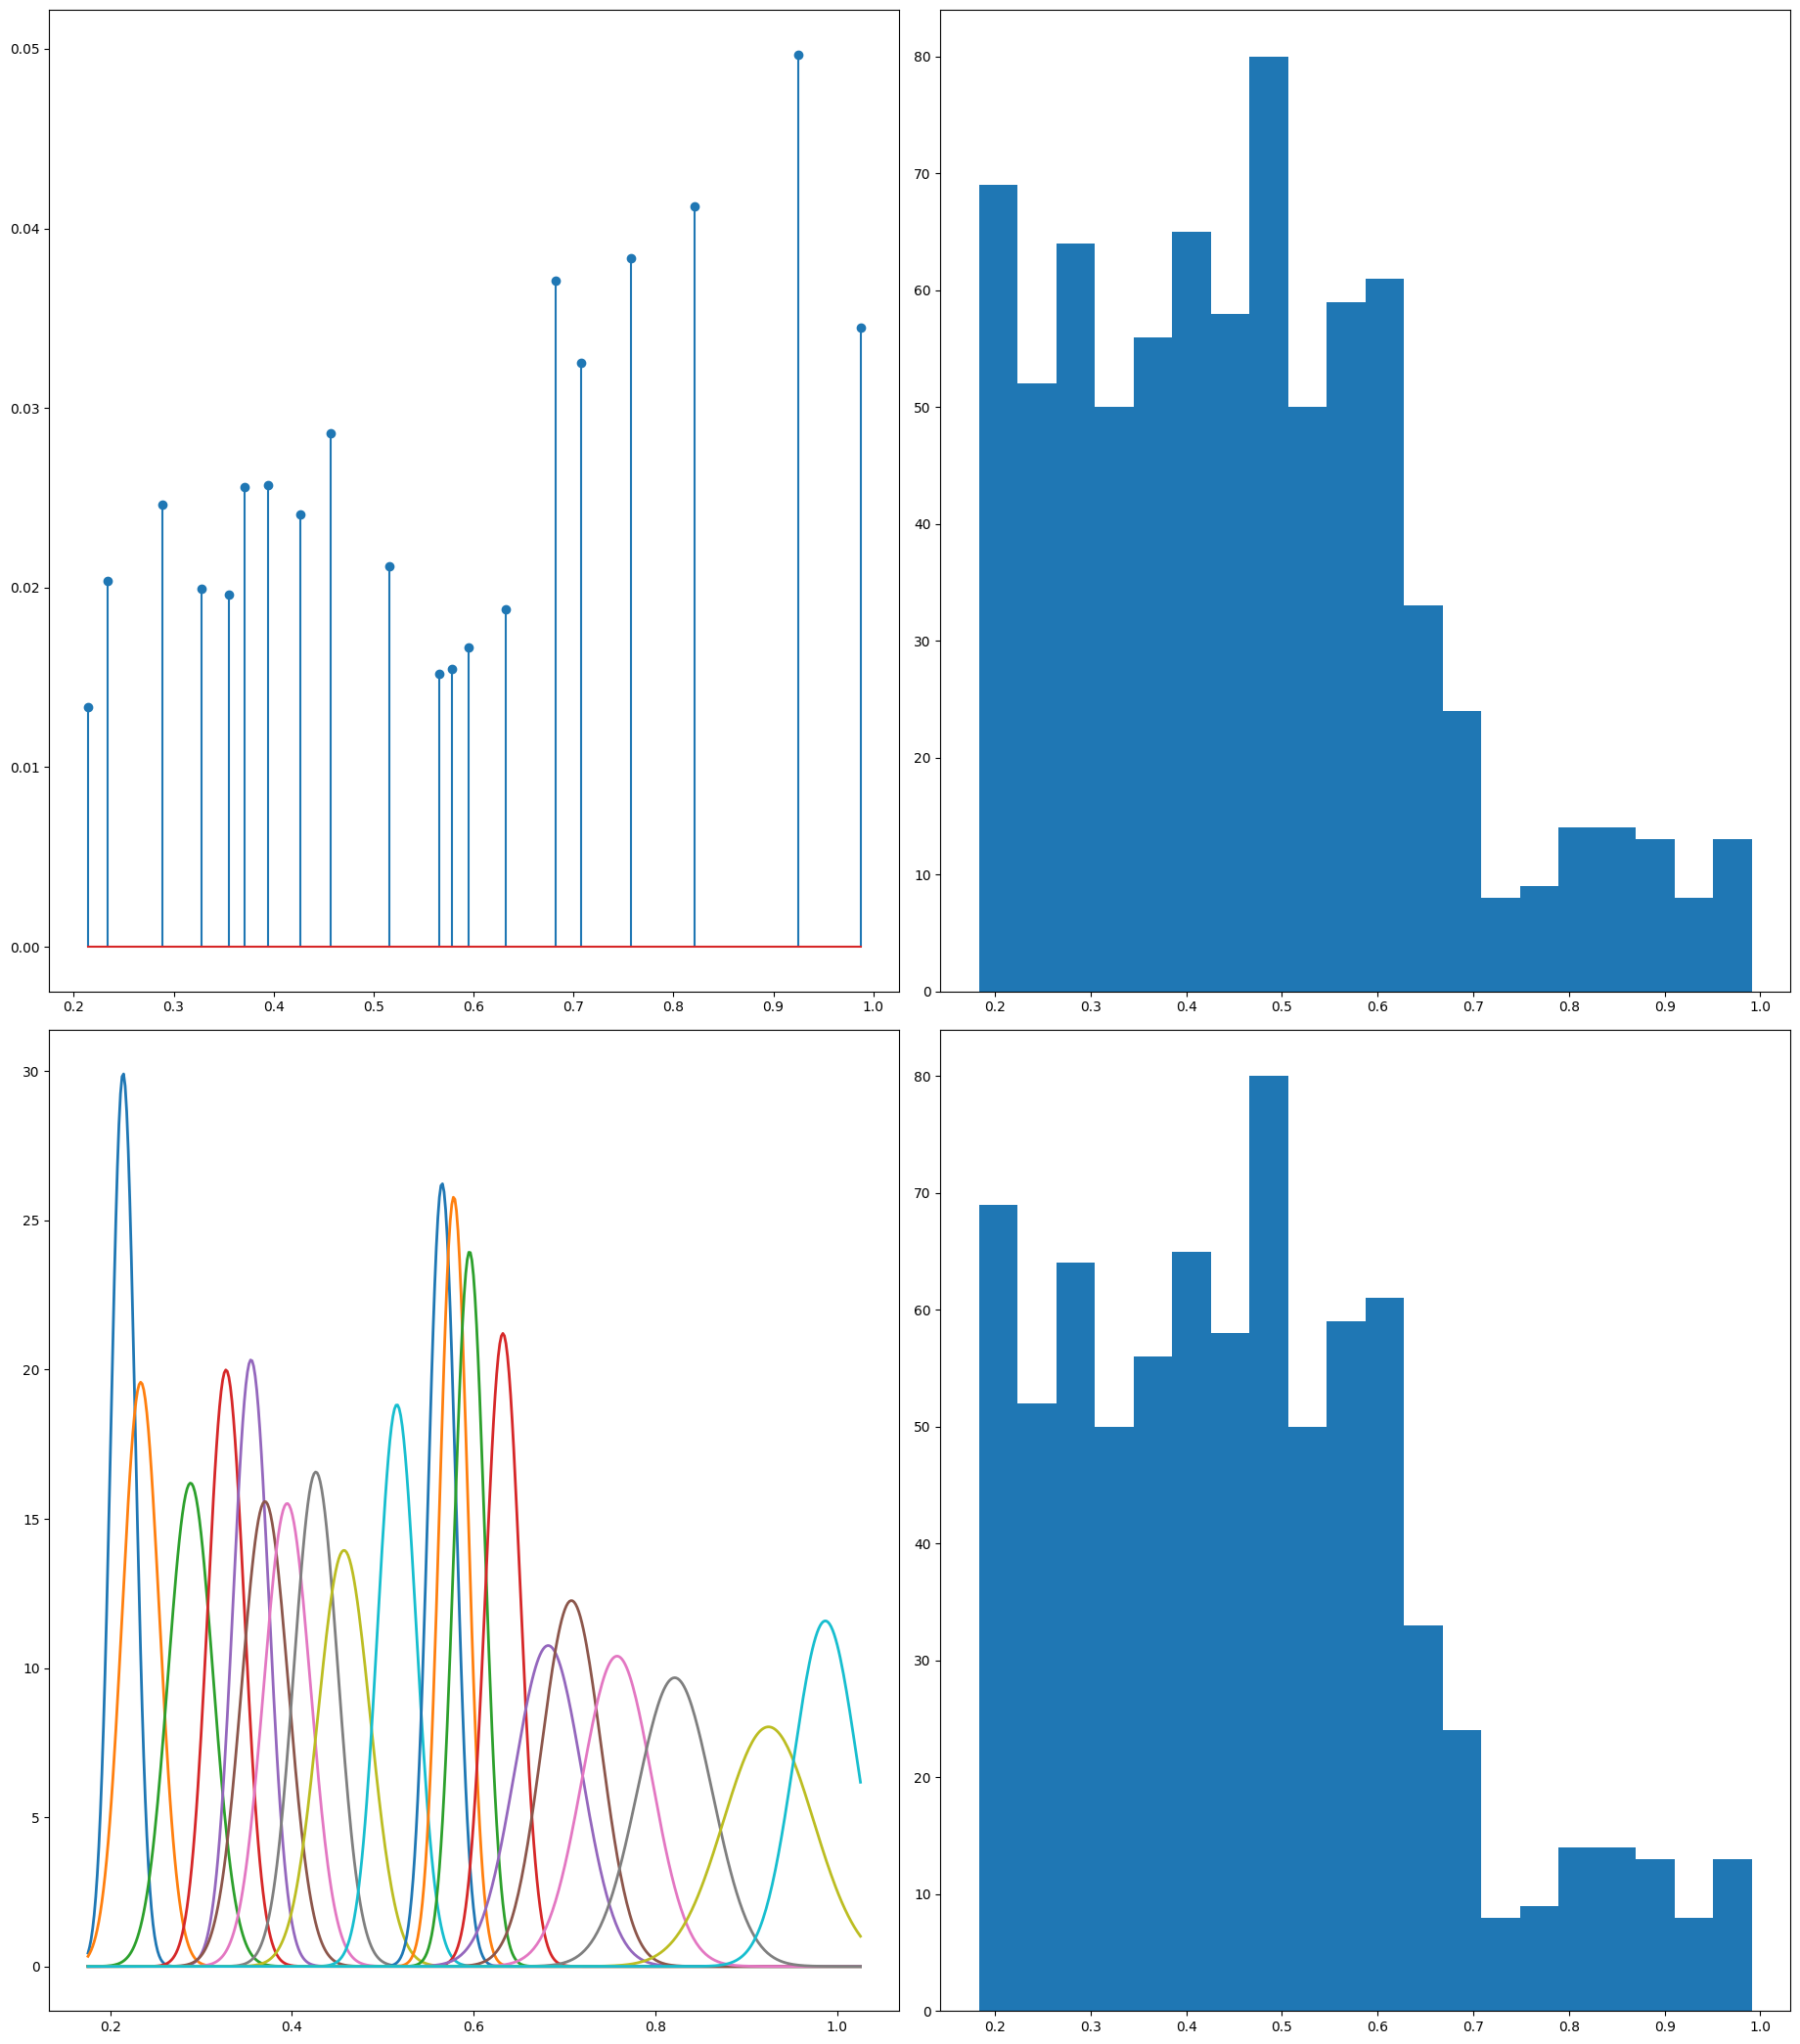

In [89]:
spn.plot_som_comparison_to_data(som_1, train_set['cleaned_humidity'].tolist())